<a href="https://colab.research.google.com/github/paulsubarna/FedWit/blob/main/vae_example_tutorial_curated_annotated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Variational AutoEncoder

In this tutorial, we will learn how to model and train our first generative latent variable model: Variational Autoencoders. It essentially connects the pieces that we had covered in our previous lectures if you recall. Happy fun Generating !!


## Imports and Setup


In [1]:
import os
#!pip install pytorch-model-summary
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from pytorch_model_summary import summary

## Dataset


This cell defines a PyTorch Dataset class for the Digits dataset, which contains images $x \in \mathbb{R}^{8 \times 8}$ with 1500 samples and pixel values in $\{0, 1, ..., 16\}$. The dataset is partitioned into train/val/test splits. This setup prepares the data for easy batching while keeping the tutorial lightweight and runnable on CPUs.

In [17]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

**Probability Distributions**

This cell implements log-likelihood functions for categorical, Bernoulli, and diagonal normal distributions, used for the VAE's likelihood and prior terms:
- *Categorical log-likelihood*: $\log p(x) = \sum_i x_i \log p_i$
- *Bernoulli log-likelihood*: $\log p(x) = x \log p + (1-x)\log(1-p)$
- *Diagonal Normal*: $\log \mathcal{N}(x;\mu,\sigma^2) = -0.5 D \log(2\pi) - 0.5\sum_j \log \sigma_j^2 - 0.5 \sum_j \frac{(x_j-\mu_j)^2}{\sigma_j^2}$

The cell enables computation of log-probabilities essential for the VAE's loss.

In [18]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(p + EPS)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_bernoulli(x, p, reduction=None, dim=None):
    log_p = x * torch.log(p + EPS) + (1. - x) * torch.log(1. - p + EPS)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_standard_normal(x, reduction=None, dim=None):
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * x**2
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


## VAE Encoder

**Encoder Module**

Defines the encoder module $q_\phi(z|x) = \mathcal{N}(z;\mu(x),\sigma^2(x)I)$, outputting parameters $\mu(x)$ and $\log \sigma^2(x)$ for each input. The *reparameterization trick* computes $z = \mu + \sigma \odot \epsilon$ for $\epsilon \sim \mathcal{N}(0,I)$, which makes VAE optimization via stochastic gradient descent possible.

In [19]:
class Encoder(nn.Module):
    def __init__(self, encoder_net):
        super(Encoder, self).__init__()

        self.encoder = encoder_net

    @staticmethod
    def reparameterization(mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def encode(self, x):
        h = self.encoder(x)
        mu_e, log_var_e = torch.chunk(h, 2, dim=1)
        return mu_e, log_var_e

    def sample(self, x=None, mu_e=None, log_var_e=None):
        if (mu_e is None) and (log_var_e is None):
            mu_e, log_var_e = self.encode(x)
        else:
            if (mu_e is None) or (log_var_e is None):
                raise ValueError('mu and log-var can`t be None!')
        z = self.reparameterization(mu_e, log_var_e)
        return z

    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        if (mu_e is None) and (log_var_e is None):
            mu_e, log_var_e = self.encode(x)
        else:
            if (mu_e is None) or (log_var_e is None):
                raise ValueError('mu and log-var can`t be None!')
        
        if z is None:
            z = self.reparameterization(mu_e, log_var_e)
        
        return log_normal_diag(z, mu_e, log_var_e, reduction='sum', dim=1)

    def forward(self, x, type='log_prob'):
        assert type in ['encode', 'log_prob'], 'Type could be either encode or log_prob'
        if type == 'encode':
            return self.encode(x)
        else:
            return self.sample(x=x), self.log_prob(x=x)


## Decoder Module

This cell sets up the VAE decoder $p_\theta(x|z)$:
- For categorical likelihood (image pixel classes), outputs are reshaped and a softmax produces pixel probabilities.
- For Bernoulli likelihood, applies a sigmoid.
Given a latent vector $z$, the decoder produces parameters for the likelihood $p_\theta(x|z)$, reconstructing images from codes.

In [20]:
class Decoder(nn.Module):
    def __init__(self, decoder_net, distribution='categorical', num_vals=None):
        super(Decoder, self).__init__()

        self.decoder = decoder_net
        self.distribution = distribution
        self.num_vals=num_vals

    def decode(self, z):
        h = self.decoder(z)
        
        if self.distribution == 'categorical':
            b = h.shape[0]
            d = h.shape[1] // self.num_vals
            h = h.view(b, d, self.num_vals)
            p = F.softmax(h, dim=2)
            return p

        elif self.distribution == 'bernoulli':
            p = torch.sigmoid(h)
            return p

        else:
            raise ValueError('Either `categorical` or `bernoulli`')

    def sample(self, z):
        p = self.decode(z)
        
        if self.distribution == 'categorical':
            # Sample from categorical distribution
            b, d, c = p.shape
            p_reshaped = p.view(b * d, c)
            x_new = torch.multinomial(p_reshaped, num_samples=1).view(b, d)
        elif self.distribution == 'bernoulli':
            x_new = torch.bernoulli(p)
        else:
            raise ValueError('Either `categorical` or `bernoulli`')

        return x_new

    def log_prob(self, x, z):
        p = self.decode(z)
        
        if self.distribution == 'categorical':
            # First sum over classes (dim=2), then over features (dim=1)
            log_p = log_categorical(x, p, num_classes=self.num_vals, reduction='sum', dim=2)
            log_p = torch.sum(log_p, dim=1)  # Sum over feature dimension to get one value per sample
        elif self.distribution == 'bernoulli':
            log_p = log_bernoulli(x, p, reduction='sum', dim=1)
        else:
            raise ValueError('Either `categorical` or `bernoulli`')
        
        return log_p

    def forward(self, z, x=None, type='log_prob'):
        assert type in ['decode', 'log_prob'], 'Type could be either decode or log_prob'
        if type == 'decode':
            return self.decode(z)
        else:
            return self.log_prob(x, z)


**Prior Module**

Implements the VAE prior $p(z) = \mathcal{N}(0, I)$:
- Sampling: $z \sim \mathcal{N}(0, I)$
- Log-probability: Computes the log-density of $z$ under the standard normal.
Intuition: Regularizes the latent space, forcing it to match a simple, tractable prior distribution.

In [21]:
class Prior(nn.Module):
    def __init__(self, L):
        super(Prior, self).__init__()
        self.L = L

    def sample(self, batch_size):
        z = torch.randn(batch_size, self.L)
        return z

    def log_prob(self, z):
        return log_standard_normal(z, reduction='sum', dim=1)


## Full VAE, Loss, and Sampling

Defines the complete VAE as a composition:

**Forward pass**:
- Encode $x$ to $ \mu(x), \log\sigma^2(x) $
- Sample $z$ using the reparameterization trick
- Decode $z$ to reconstruct $x$ (e.g., BCE/MSE loss)
- Compute the Evidence Lower Bound (ELBO):
$$
       \mathcal{L}_{\text{VAE}} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - \mathrm{KL}(q(z|x)||p(z))
$$

The KL term is for two diagonal Gaussians and the reconstruction from the chosen likelihood.

### Sampling
This cell draws $z\sim\mathcal{N}(0,I)$ and decodes to generate new samples $\hat x\sim p_\theta(x\mid z)$.

In [22]:
class VAE(nn.Module):
    def __init__(self, encoder_net, decoder_net, num_vals=256, L=16, likelihood_type='categorical'):
        super(VAE, self).__init__()

        print('VAE model constructed.')

        self.encoder = Encoder(encoder_net=encoder_net)
        self.decoder = Decoder(distribution=likelihood_type, decoder_net=decoder_net, num_vals=num_vals)
        self.prior = Prior(L=L)

        self.num_vals = num_vals

        self.likelihood_type = likelihood_type

    def forward(self, x, reduction='avg'):
        # Encode
        mu_e, log_var_e = self.encoder.encode(x)
        
        # Sample z using reparameterization trick
        z = self.encoder.reparameterization(mu_e, log_var_e)
        
        # Calculate log q(z|x)
        log_q_z = self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)
        
        # Calculate log p(z)
        log_p_z = self.prior.log_prob(z)
        
        # Calculate log p(x|z)
        log_p_x_z = self.decoder.log_prob(x, z)
        
        # Calculate ELBO
        # ELBO = E[log p(x|z)] - KL(q(z|x)||p(z))
        # KL = log q(z|x) - log p(z)
        RE = log_p_x_z
        KL = log_q_z - log_p_z
        
        # Loss is negative ELBO
        loss = -RE + KL
        
        if reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()

    def sample(self, batch_size=64):
        # Sample from prior
        z = self.prior.sample(batch_size)
        
        # Decode
        x_generated = self.decoder.sample(z)
        
        return x_generated


## Auxiliary Functions: Training, Evaluation, Plotting

Implements utility functions for model training, validation/testing, and result visualization:
- Computes and tracks loss (negative ELBO)
- Saves models and generated samples
- Plots the training curve, outputs images
These tools facilitate model development and result inspection.

In [23]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # Load best model
        model_best = torch.load(name + '.model')
    
    model_best.eval()
    loss = 0.
    N = 0.
    
    with torch.no_grad():
        for indx_batch, batch in enumerate(test_loader):
            loss_t = model_best.forward(batch, reduction='sum')
            loss = loss + loss_t.item()
            N = N + batch.shape[0]
    
    loss = loss / N
    
    if epoch is not None:
        print(f'Epoch: {epoch}, val loss: {loss:.4f}')
    
    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()


### Optimization setup
This cell configures the optimizer and learning-rate schedule used to minimize $\mathcal{L}_{\text{VAE}}=\text{ReconLoss}+\mathrm{KL}$.

### Training loop
For each batch: encode $x\to(\mu,\sigma)$, sample $z$, decode to $\hat x$, compute losses, backprop, and update parameters.

In [24]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        train_loss = 0.
        train_N = 0.
        for indx_batch, batch in enumerate(training_loader):
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch.shape[0]
            train_N += batch.shape[0]
        
        train_loss = train_loss / train_N
        print(f'Epoch: {e}, Train loss: {train_loss:.4f}')

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0
            else:
                patience = patience + 1

        # Generate samples periodically
        if e % 10 == 0:
            samples_generated(name, val_loader, extra_name="_epoch_" + str(e))

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val


## Initialize dataloaders

**Hyperparameters**

Specifies model hyperparameters:
- Input dim $D$, latent dim $L$, network size $M$
- Learning rate, epochs, early stopping
These control model structure, speed, and regularization.

In [25]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'vae'

### Hyperparams

**Instantiate Model & Summaries**

Chooses the likelihood type, configures encoder/decoder, and creates the VAE object. Model summaries help verify correct shapes and parameters.

In [26]:
D = 64   # input dimension
L = 16  # number of latents
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

### Initialize VAE

**Optimizer Setup**

Configures the optimizer (Adamax) and sets the learning rate for updating model parameters.

In [27]:
likelihood_type = 'categorical'

if likelihood_type == 'categorical':
    num_vals = 17
elif likelihood_type == 'bernoulli':
    num_vals = 1

# Encoder network: input D -> hidden layers -> 2*L (for mu and log_var)
encoder = nn.Sequential(
    nn.Linear(D, M),
    nn.ReLU(),
    nn.Linear(M, M),
    nn.ReLU(),
    nn.Linear(M, 2 * L)  # Output both mu and log_var
)

# Decoder network: input L -> hidden layers -> output depends on likelihood
if likelihood_type == 'categorical':
    decoder = nn.Sequential(
        nn.Linear(L, M),
        nn.ReLU(),
        nn.Linear(M, M),
        nn.ReLU(),
        nn.Linear(M, D * num_vals)  # For categorical, output logits for each class
    )
elif likelihood_type == 'bernoulli':
    decoder = nn.Sequential(
        nn.Linear(L, M),
        nn.ReLU(),
        nn.Linear(M, M),
        nn.ReLU(),
        nn.Linear(M, D)  # For Bernoulli, output logits
    )

prior = Prior(L=L)
model = VAE(encoder_net=encoder, decoder_net=decoder, num_vals=num_vals, L=L, likelihood_type=likelihood_type)

# Print the summary (like in Keras)
print("ENCODER:\n", summary(encoder, torch.zeros(1, D), show_input=False, show_hierarchical=False))
print("\nDECODER:\n", summary(decoder, torch.zeros(1, L), show_input=False, show_hierarchical=False))


VAE model constructed.
ENCODER:
 -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 256]          16,640          16,640
            ReLU-2            [1, 256]               0               0
          Linear-3            [1, 256]          65,792          65,792
            ReLU-4            [1, 256]               0               0
          Linear-5             [1, 32]           8,224           8,224
Total params: 90,656
Trainable params: 90,656
Non-trainable params: 0
-----------------------------------------------------------------------

DECODER:
 -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 256]           4,352           4,352
            ReLU-2            [1, 256]               0               0
          Linear-3            [

### Let's play! Training

### Optimization setup
This cell configures the optimizer and learning-rate schedule used to minimize $\mathcal{L}_{\text{VAE}}=\text{ReconLoss}+\mathrm{KL}$.

**How to verify it worked:** run without errors; if training, confirm the loss decreases across iterations/epochs.

**Training Procedure**

Runs the training loop with early stopping. Periodically saves weights if validation loss improves and visualizes progress.

In [28]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

**Testing and Visualization**

Evaluates the best model on the test set, saves loss and sample images, and learning curve plots.

In [29]:
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, Train loss: 158.0815
Epoch: 0, val loss: 125.4870
saved!
Epoch: 1, Train loss: 113.0639
Epoch: 1, val loss: 112.9043
saved!
Epoch: 2, Train loss: 108.9361
Epoch: 2, val loss: 112.0877
saved!
Epoch: 3, Train loss: 108.3644
Epoch: 3, val loss: 111.7962
saved!
Epoch: 4, Train loss: 108.0246
Epoch: 4, val loss: 111.7288
saved!
Epoch: 5, Train loss: 108.0448
Epoch: 5, val loss: 111.4893
saved!
Epoch: 6, Train loss: 107.8962
Epoch: 6, val loss: 111.3724
saved!
Epoch: 7, Train loss: 107.8196
Epoch: 7, val loss: 111.3722
saved!
Epoch: 8, Train loss: 107.7119
Epoch: 8, val loss: 111.2217
saved!
Epoch: 9, Train loss: 107.7687
Epoch: 9, val loss: 111.3081
Epoch: 10, Train loss: 107.7145
Epoch: 10, val loss: 111.3842
Epoch: 11, Train loss: 107.6273
Epoch: 11, val loss: 111.3832
Epoch: 12, Train loss: 107.5341
Epoch: 12, val loss: 111.1289
saved!
Epoch: 13, Train loss: 107.4272
Epoch: 13, val loss: 111.0730
saved!
Epoch: 14, Train loss: 107.4437
Epoch: 14, val loss: 110.8846
saved!
Epoch:


**How to verify it worked:** run without errors; if training, confirm the loss decreases across iterations/epochs.

In [30]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

## Visualization TO-DO

### **Objective**
Analyze and interpret the geometry of the learned latent space.

### **Instructions**
1. Select a dataset sample (images or other input) and encode it into the latent space using the VAE encoder.
2. Apply a dimensionality reduction technique if needed (e.g., PCA or t-SNE) to project latent vectors to 2D.
3. Visualize the resulting 2D latent representations.
4. If labels are available, color points by class.
5. Train the model with different number of latent variables






LATENT SPACE VISUALIZATION
Model loaded successfully!

1. Encoding test samples into latent space...
   Encoded 447 samples into 16D latent space

2. Applying PCA to project from 16D to 2D...
   Explained variance: 0.396

3. Visualizing latent space...


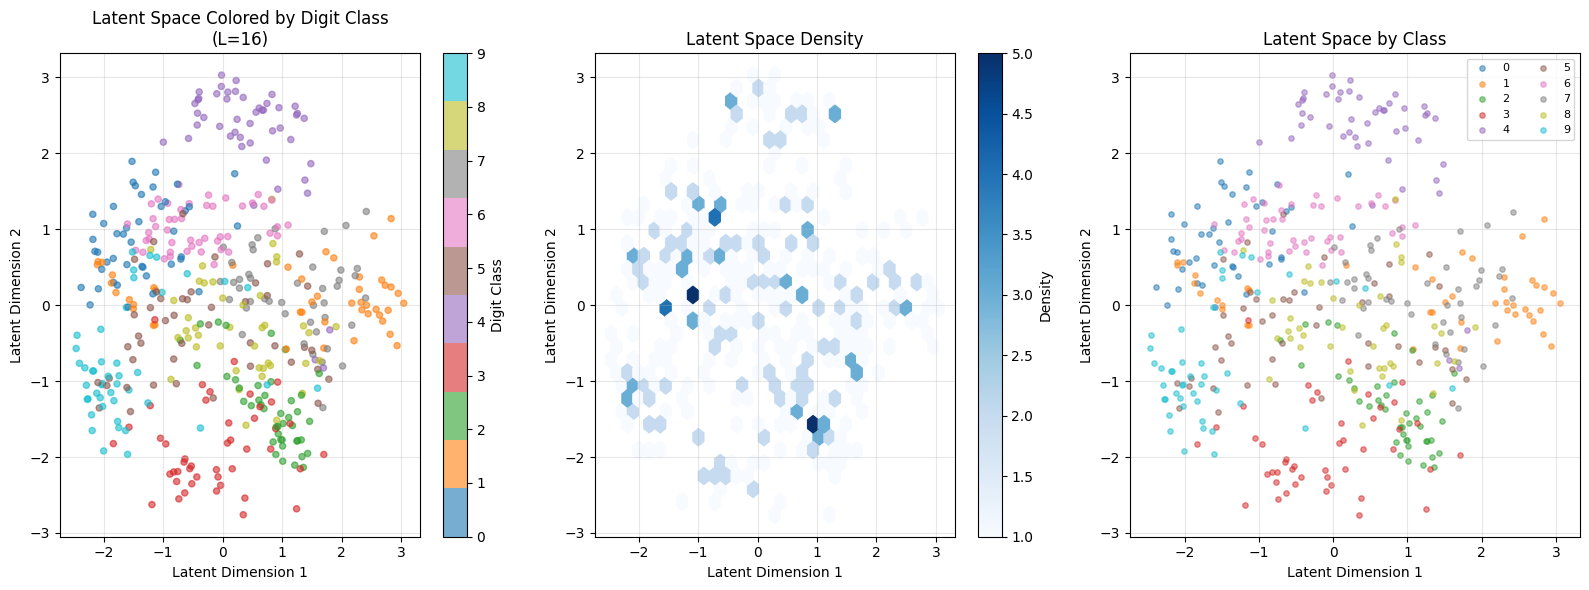


4. Latent space statistics:
   Mean: [-0.00036358  0.02626001  0.13115683 -0.00636392  0.05522117]... (first 5 dims)
   Std:  [1.0860791  0.41646177 0.93954223 1.1054375  1.2294123 ]... (first 5 dims)

5. Training models with different latent dimensions...
   Testing L = 2, 8, 16, 32

   Training with L=2...
VAE model constructed.
      Final val loss: 111.3577

   Training with L=8...
VAE model constructed.
      Final val loss: 111.2957

   Training with L=16...
VAE model constructed.
      Final val loss: 111.1190

   Training with L=32...
VAE model constructed.
      Final val loss: 110.8192

6. Plotting comparison of different L values...


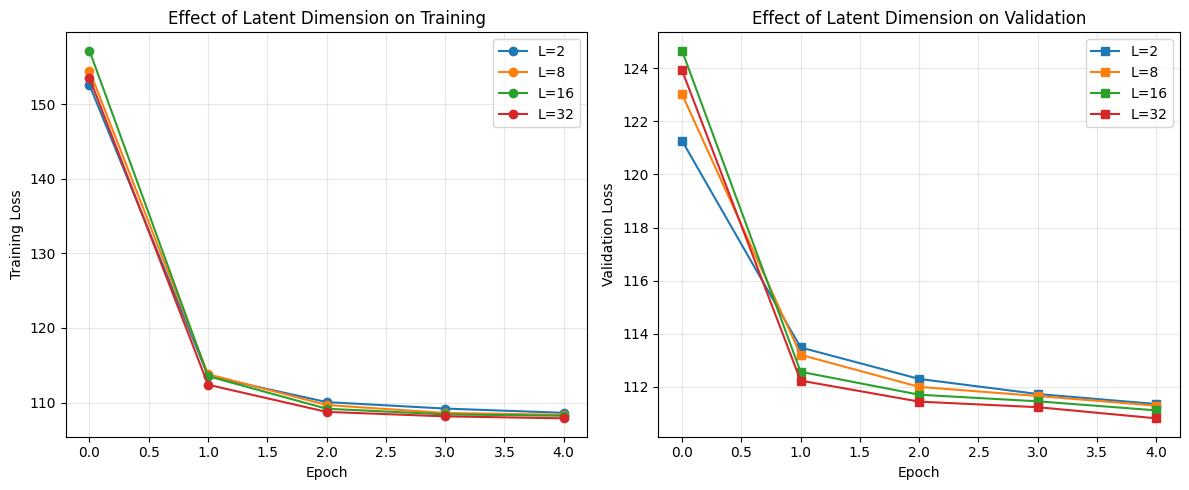

In [31]:
# Visualization of Latent Space

print("=" * 70)
print("LATENT SPACE VISUALIZATION")
print("=" * 70)

# Load the trained model
try:
    model_trained = torch.load(result_dir + name + '.model')
    model_trained.eval()
    print("Model loaded successfully!")
    
    # 1. Encode all test samples into latent space
    print("\n1. Encoding test samples into latent space...")
    all_z = []
    all_labels = []
    
    # Get labels if available (load_digits returns labels)
    digits_full = load_digits()
    test_labels = digits_full.target[1350:]  # Test split labels
    
    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            mu_e, log_var_e = model_trained.encoder.encode(batch)
            # Use mean of the distribution for visualization
            all_z.append(mu_e.cpu().numpy())
    
    all_z = np.concatenate(all_z, axis=0)
    print(f"   Encoded {all_z.shape[0]} samples into {all_z.shape[1]}D latent space")
    
    # 2. Apply dimensionality reduction if L > 2
    if L > 2:
        print(f"\n2. Applying PCA to project from {L}D to 2D...")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        z_2d = pca.fit_transform(all_z)
        print(f"   Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    else:
        z_2d = all_z
        print(f"\n2. Latent space is already 2D, no reduction needed.")
    
    # 3. Visualize the 2D latent space
    print("\n3. Visualizing latent space...")
    
    plt.figure(figsize=(16, 6))
    
    # Plot with color by digit class
    plt.subplot(1, 3, 1)
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=test_labels[:len(z_2d)], 
                         cmap='tab10', alpha=0.6, s=20)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(f'Latent Space Colored by Digit Class\n(L={L})')
    plt.grid(True, alpha=0.3)
    
    # Plot density
    plt.subplot(1, 3, 2)
    plt.hexbin(z_2d[:, 0], z_2d[:, 1], gridsize=30, cmap='Blues', mincnt=1)
    plt.colorbar(label='Density')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Density')
    plt.grid(True, alpha=0.3)
    
    # Plot distribution per class
    plt.subplot(1, 3, 3)
    for digit in range(10):
        mask = test_labels[:len(z_2d)] == digit
        plt.scatter(z_2d[mask, 0], z_2d[mask, 1], 
                   label=f'{digit}', alpha=0.5, s=15)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space by Class')
    plt.legend(ncol=2, fontsize=8)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(result_dir + name + '_latent_space.pdf', bbox_inches='tight')
    plt.show()
    
    # 4. Analyze latent dimensions
    print("\n4. Latent space statistics:")
    print(f"   Mean: {all_z.mean(axis=0)[:5]}... (first 5 dims)")
    print(f"   Std:  {all_z.std(axis=0)[:5]}... (first 5 dims)")
    
    # 5. Compare different values of L
    print("\n5. Training models with different latent dimensions...")
    print("   Testing L = 2, 8, 16, 32")
    
    L_values = [2, 8, 16, 32]
    results_L = {}
    
    for L_test in L_values:
        print(f"\n   Training with L={L_test}...")
        
        # Create encoder/decoder
        encoder_test = nn.Sequential(
            nn.Linear(D, M),
            nn.ReLU(),
            nn.Linear(M, M),
            nn.ReLU(),
            nn.Linear(M, 2 * L_test)
        )
        
        if likelihood_type == 'categorical':
            decoder_test = nn.Sequential(
                nn.Linear(L_test, M),
                nn.ReLU(),
                nn.Linear(M, M),
                nn.ReLU(),
                nn.Linear(M, D * num_vals)
            )
        else:
            decoder_test = nn.Sequential(
                nn.Linear(L_test, M),
                nn.ReLU(),
                nn.Linear(M, M),
                nn.ReLU(),
                nn.Linear(M, D)
            )
        
        model_test = VAE(encoder_net=encoder_test, decoder_net=decoder_test, 
                        num_vals=num_vals, L=L_test, likelihood_type=likelihood_type)
        optimizer_test = torch.optim.Adamax([p for p in model_test.parameters() if p.requires_grad], lr=lr)
        
        # Brief training (5 epochs for comparison)
        model_test.train()
        train_losses = []
        val_losses = []
        
        for epoch in range(5):
            # Train
            epoch_loss = 0.
            for batch in training_loader:
                loss = model_test.forward(batch)
                optimizer_test.zero_grad()
                loss.backward()
                optimizer_test.step()
                epoch_loss += loss.item()
            train_losses.append(epoch_loss / len(training_loader))
            
            # Validate
            model_test.eval()
            val_loss = 0.
            with torch.no_grad():
                for batch in val_loader:
                    val_loss += model_test.forward(batch).item()
            val_losses.append(val_loss / len(val_loader))
            model_test.train()
        
        results_L[L_test] = {
            'train': train_losses,
            'val': val_losses,
            'final_val': val_losses[-1]
        }
        print(f"      Final val loss: {val_losses[-1]:.4f}")
    
    # Plot comparison
    print("\n6. Plotting comparison of different L values...")
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for L_test in L_values:
        plt.plot(results_L[L_test]['train'], 'o-', label=f'L={L_test}')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Effect of Latent Dimension on Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    for L_test in L_values:
        plt.plot(results_L[L_test]['val'], 's-', label=f'L={L_test}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Effect of Latent Dimension on Validation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(result_dir + name + '_latent_dim_comparison.pdf', bbox_inches='tight')
    plt.show()
    
except FileNotFoundError:
    print("Model not found. Please train the model first!")
    print("Run the training cell before this visualization.")
except Exception as e:
    print(f"Error: {e}")
    print("Make sure the model is trained and all dependencies are installed.")
